In [1]:
using Distributions
using StatsPlots
default(fmt=:png)
using Random
using KernelDensity

In [2]:
function mcsim(;
        n = 100,
        L = 5*10^5,
        dist = Normal(1, 2)
    )
    μ, σ = mean(dist), std(dist)
    Z = Vector{Float64}(undef, L)
    R = similar(Z)
    tmp = [Vector{Float64}(undef, n) for i in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        X̄, S = mean(X), std(X)
        Z[i] = √n * (X̄ - μ) / σ
        R[i] = σ / S
        # T-statistic = Z * R
    end
    Z, R
end

safediv(x, y) = y == 0 ? y : x/y

safediv (generic function with 1 method)

  0.171539 seconds (437.18 k allocations: 25.272 MiB, 98.58% compilation time)


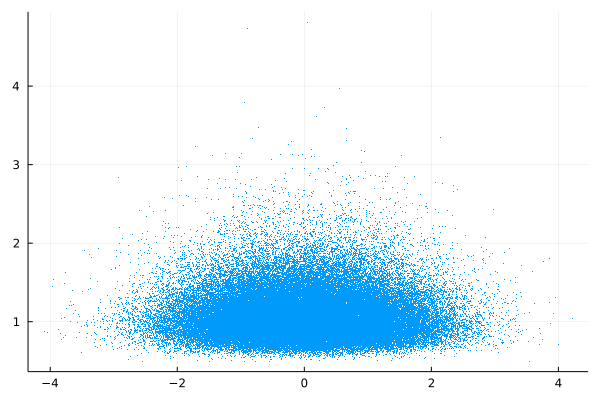

In [3]:
@time Z, R = mcsim(n = 10, L = 10^5)
scatter(Z, R; msa=0.1, msc=:auto, ms=1, label="")

  0.321381 seconds (10.86 M allocations: 209.960 MiB, 3.67% gc time, 47.40% compilation time)


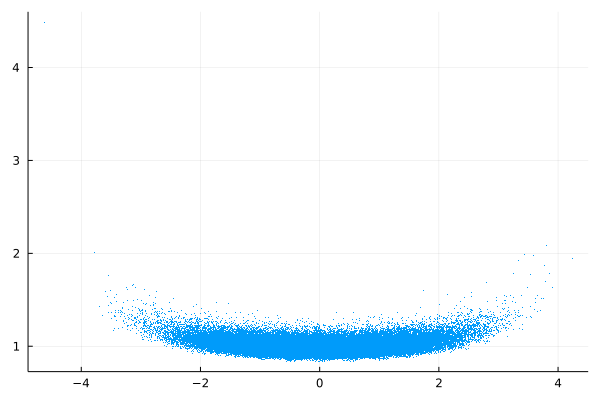

In [4]:
#@time Z, R = mcsim(dist = Normal(1, 2), n = 10)
#@time Z, R = mcsim(dist = Uniform(), n = 10)
@time Z, R = mcsim(dist = Beta(0.2, 0.2), n = 20)
#@time Z, R = mcsim(dist = Beta(0.5, 0.5), n = 10)
#@time Z, R = mcsim(dist = TDist(4.1), n = 20)
#@time Z, R = mcsim(dist = LogNormal(), n = 400)
#@time Z, R = mcsim(dist = Gamma(10, 1), n = 20)
#@time Z, R = mcsim(dist = Gamma(1, 1), n = 20)
scatter(Z[1:10^5], R[1:10^5]; msa=0.1, msc=:auto, ms=1, label="")
#plot!(; ylim = (0.8, 1.5), ytick=0:0.1:5)

In [5]:
kdeZR = InterpKDE(kde((Z, R)))
f(z, r) = pdf(kdeZR, z, r)
r = range(0.8, 1.5, 100)
scatter(Z, R; ms=1, mc=:auto, msw=0, label="", zcolor=f)
plot!([2r -2r], r; label="")
plot!(; xlim=extrema(z), ylim=extrema(r))

LoadError: UndefVarError: z not defined

In [6]:
T = Z .* R
kdeTR = InterpKDE(kde((T, R)))
F(t, r) = pdf(kdeTR, t, r)
r = range(0.8, 1.5, 100)
scatter(T, R; ms=1, mc=:auto, msw=0, label="", zcolor=f)
plot!([2*.√r -2*.√r], r; label="", c=:cyan)
plot!(; xlim=extrema(t), ylim=extrema(r))

LoadError: UndefVarError: t not defined

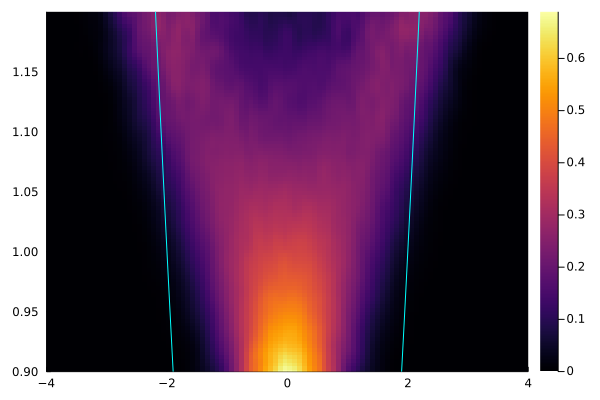

In [7]:
kdeR = InterpKDE(kde(R))
g(z, r) = safediv(pdf(kdeZR, z, r), pdf(kdeR, r))
z = range(-4, 4, 100)
r = range(0.9, 1.2, 100)
heatmap(z, r, g)
#scatter(Z, R; ms=1, mc=:auto, msw=0, label="", zcolor=g)
#plot!([2r -2r], r; label="", c=:cyan)
plot!([2*.√r -2*.√r], r; label="", c=:cyan)
plot!(; xlim=extrema(z), ylim=extrema(r))

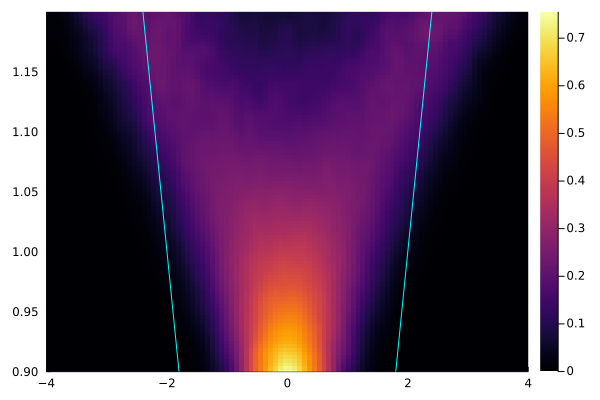

In [8]:
kdeR = InterpKDE(kde(R))
G(t, r) = safediv(pdf(kdeTR, t, r), pdf(kdeR, r))
t = range(-4, 4, 100)
r = range(0.9, 1.2, 100)
heatmap(t, r, G)
#scatter(Z, R; ms=1, mc=:auto, msw=0, label="", zcolor=g)
plot!([2r -2r], r; label="", c=:cyan)
plot!(; xlim=extrema(t), ylim=extrema(r))

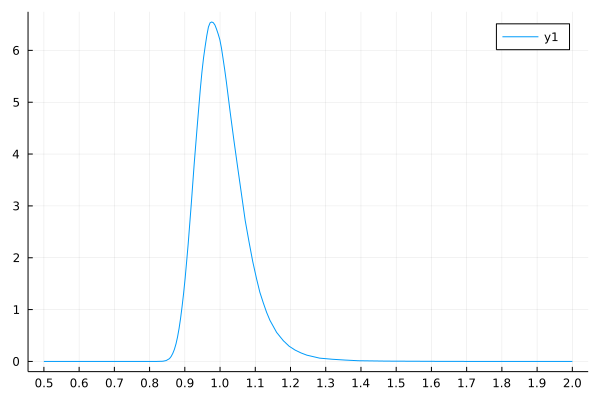

In [9]:
plot(r -> pdf(kdeR, r), 0.5, 2; xtick = 0:0.1:10)

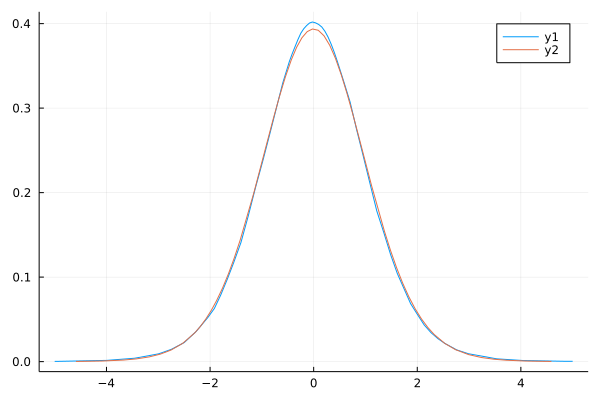

In [10]:
kdeT = InterpKDE(kde(R .* Z))
plot(t -> pdf(kdeT, t), -5, 5)
plot!(TDist(19))

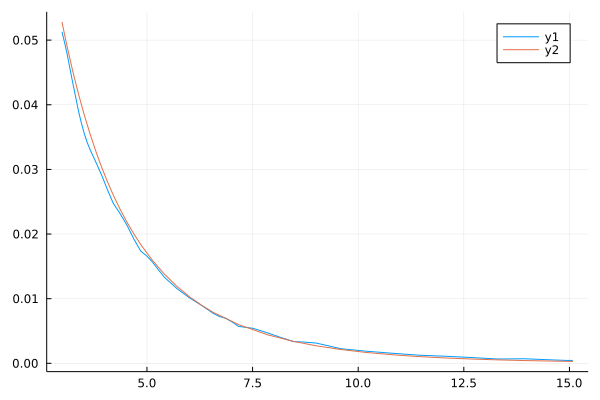

In [11]:
kdeF = InterpKDE(kde((R .* Z).^2))
fdist = FDist(1, 19)
plot(t -> pdf(kdeF, t), quantile(fdist, 0.9), quantile(fdist, 0.999))
plot!(fdist, quantile(fdist, 0.9), quantile(fdist, 0.999))

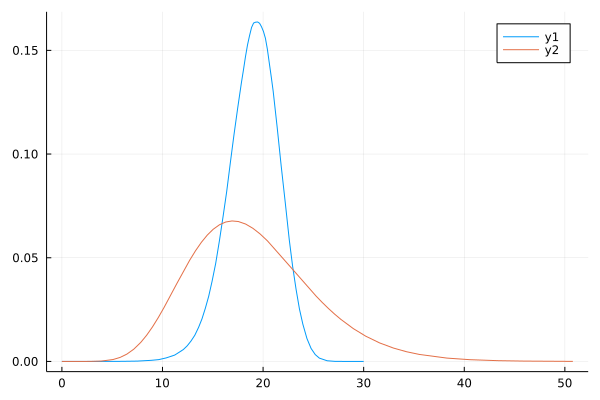

In [12]:
Chisq19 = 19 ./ R.^2
k = InterpKDE(kde(Chisq19))
plot(x -> pdf(k, x), 0, 30)
plot!(Chisq(19))

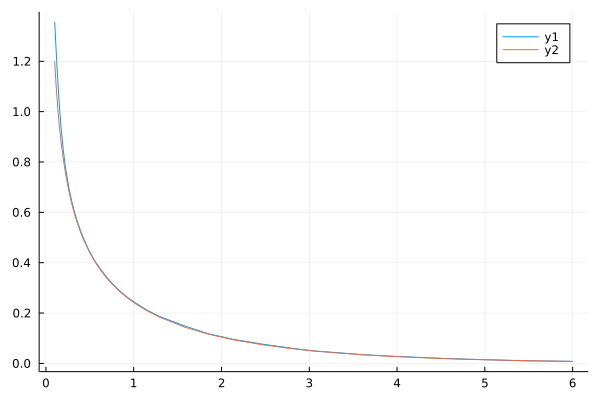

In [13]:
Chisq1 = Z.^2
k = InterpKDE(kde(Chisq1))
plot(x -> pdf(k, x), 0.1, 6)
plot!(Chisq(1), 0.1, 6)